In [229]:
import pandas as pd
import numpy as np

from starknet_py.net.account.account import Account
from starknet_py.net.full_node_client import FullNodeClient
from starknet_py.net.models.chains import StarknetChainId
from starknet_py.net.signer.key_pair import KeyPair
from starknet_py.net.signer.stark_curve_signer import StarkCurveSigner
from starknet_py.contract import Contract

from cauchy_simulations import CauchyLiquidityProfile, ModifiedCauchyLiquidityProfile, from_bps_tick

In [230]:
client = FullNodeClient(node_url="https://rpc.starknet.lava.build:443")

In [231]:
account = Account(
    client=client,
    address="0x4321",
    key_pair=KeyPair(private_key=654, public_key=321),
    chain=StarknetChainId.MAINNET,
)

In [232]:
LP_ADDRESS = "0x0745f3180bba2826c33fc66f9571bcb9731d7a55d71e8d935fac5f3e6a8aa1e4"
CORE_ADDRESS = "0x5dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b"
PROFILE_ADDRESS = "0x00ee96ce32dfc401a8eb7da1f6f40bc0a9e58ff53d6112a2b92a505db6bc7f77"

In [233]:
lp_contract = await Contract.from_address(address=LP_ADDRESS, provider=account)

/Users/beta/Documents/src/smolquants/cauchy-simulations-2025-03/.venv/lib/python3.11/site-packages/starknet_py/proxy/contract_abi_resolver.py:223: IncompatibleRPCVersionWarning: RPC node with the url https://rpc.starknet.lava.build:443 uses incompatible version 0.7.1. Expected version: 0.8.1
  contract_class_hash = await client.get_class_hash_at(contract_address=address)


In [234]:
lp_contract.functions.keys()

dict_keys(['get_primary_interface_id', 'create_and_initialize_pool', 'add_liquidity', 'remove_liquidity', 'core', 'profile', 'pool_token', 'pool_liquidity_factor', 'pool_reserves', 'pool_minimum_liquidity_factor', 'locked', 'before_initialize_pool', 'after_initialize_pool', 'before_swap', 'after_swap', 'before_update_position', 'after_update_position', 'before_collect_fees', 'after_collect_fees', 'get_owner', 'transfer_ownership', 'replace_class_hash', 'sweep'])

In [235]:
await lp_contract.functions['core'].call()

(OrderedDict([('contract_address',
               158098919692956613592021320609952044916245725306097615271255138786123)]),)

In [236]:
0x5dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b

158098919692956613592021320609952044916245725306097615271255138786123

In [237]:
await lp_contract.functions['profile'].call()

(OrderedDict([('contract_address',
               421550422475953920814934336055981319435134360651993758546453665490040291191)]),)

In [238]:
# WBTC/WWBTC 1bps fee, 0.01bps spacing pool
pool_key = {
    "token0": 0x03fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac, # token0
    "token1": 0x0577bddfccc35c714e99638d4f03ee6bc51e38895c7abc4df1b1e1ab4854b2ce, # token1
    "fee": 34028236692093846346337460743176821, # fee
    "tick_spacing": 1, # tick spacing
    "extension": 0x0745f3180bba2826c33fc66f9571bcb9731d7a55d71e8d935fac5f3e6a8aa1e4, # extension
}

In [239]:
0x00ee96ce32dfc401a8eb7da1f6f40bc0a9e58ff53d6112a2b92a505db6bc7f77

421550422475953920814934336055981319435134360651993758546453665490040291191

In [240]:
await lp_contract.functions['pool_reserves'].call(pool_key)

((9763, 10465),)

In [241]:
core_contract = await Contract.from_address(address=CORE_ADDRESS, provider=account)

In [242]:
core_contract.functions.keys()

dict_keys(['get_primary_interface_id', 'get_protocol_fees_collected', 'get_locker_state', 'get_locker_delta', 'get_pool_price', 'get_pool_liquidity', 'get_pool_fees_per_liquidity', 'get_pool_fees_per_liquidity_inside', 'get_pool_tick_liquidity_delta', 'get_pool_tick_liquidity_net', 'get_pool_tick_fees_outside', 'get_position', 'get_position_with_fees', 'get_saved_balance', 'next_initialized_tick', 'prev_initialized_tick', 'withdraw_all_protocol_fees', 'withdraw_protocol_fees', 'lock', 'forward', 'withdraw', 'save', 'pay', 'load', 'initialize_pool', 'maybe_initialize_pool', 'update_position', 'collect_fees', 'swap', 'accumulate_as_fees', 'set_call_points', 'get_call_points', 'get_owner', 'transfer_ownership', 'replace_class_hash'])

In [243]:
profile_contract = await Contract.from_address(address=PROFILE_ADDRESS, provider=account)

In [244]:
profile_contract.functions.keys()

dict_keys(['initial_liquidity_factor', 'description', 'set_liquidity_profile', 'get_liquidity_profile', 'get_liquidity_updates', 'get_bounds_for_liquidity_updates'])

In [245]:
ZERO_I129 = {
    "mag": 0,
    "sign": False,
}

In [246]:
(liquidity_update_params,) = await profile_contract.functions['get_liquidity_updates'].call(pool_key, ZERO_I129)

In [247]:
data = {'tick': [], 'liquidity_delta': []}

In [248]:
for params in liquidity_update_params:
    position_key = {
        "salt": 0,
        "owner": 0x0745f3180bba2826c33fc66f9571bcb9731d7a55d71e8d935fac5f3e6a8aa1e4,
        "bounds": params['bounds']
    }
    (result, ) = await core_contract.functions['get_position'].call(pool_key, position_key)

    tick_lower = -params['bounds']['lower']['mag'] if params['bounds']['lower']['sign'] else params['bounds']['lower']['mag']
    tick_upper = -params['bounds']['upper']['mag'] if params['bounds']['upper']['sign'] else params['bounds']['upper']['mag']
    data['tick'].extend([tick_lower])

    liquidity = result['liquidity']
    print(f"result: {result}")
    data['liquidity_delta'].extend([liquidity])


result: OrderedDict([('liquidity', 4285), ('fees_per_liquidity_inside_last', OrderedDict([('value0', 4809319031949539721222171767591270), ('value1', 4588352756053428716578677646204824)]))])
result: OrderedDict([('liquidity', 67579), ('fees_per_liquidity_inside_last', OrderedDict([('value0', 4809319031949539721222171767591270), ('value1', 4588352756053428716578677646204824)]))])
result: OrderedDict([('liquidity', 20273), ('fees_per_liquidity_inside_last', OrderedDict([('value0', 4809319031949539721222171767591270), ('value1', 4588352756053428716578677646204824)]))])
result: OrderedDict([('liquidity', 30868), ('fees_per_liquidity_inside_last', OrderedDict([('value0', 4809319031949539721222171767591270), ('value1', 4588352756053428716578677646204824)]))])
result: OrderedDict([('liquidity', 50229), ('fees_per_liquidity_inside_last', OrderedDict([('value0', 4809319031949539721222171767591270), ('value1', 4588352756053428716578677646204824)]))])
result: OrderedDict([('liquidity', 89443), ('f

In [249]:
df = pd.DataFrame(data=data)
df = df.sort_values(by='tick')

In [250]:
df

,tick,liquidity_delta
0,-88722883,4285
1,-16000,67579
2,-14000,20273
3,-12000,30868
4,-10000,50229
5,-8000,89443
6,-7000,73130
7,-6000,107744
8,-5000,166620
9,-4000,272649


In [251]:
data_flip = {
    'tick': -df.sort_values(by='tick', ascending=False)['tick'],
    'liquidity_delta': -df.sort_values(by='tick', ascending=False)['liquidity_delta'].shift(fill_value=0),
}

In [252]:
df_flip = pd.DataFrame(data=data_flip)
df_flip

,tick,liquidity_delta
20,250,0
19,500,-190812
18,750,-283171
17,1000,-336972
16,1250,-355363
15,1500,-347466
14,1750,-323424
13,2000,-291551
12,2500,-482122
11,3000,-362622


In [253]:
df_total = pd.concat([df, df_flip])
df_total

,tick,liquidity_delta
0,-88722883,4285
1,-16000,67579
2,-14000,20273
3,-12000,30868
4,-10000,50229
5,-8000,89443
6,-7000,73130
7,-6000,107744
8,-5000,166620
9,-4000,272649


In [254]:
df_total['liquidity'] = df_total['liquidity_delta'].cumsum()

In [255]:
df_total

,tick,liquidity_delta,liquidity
0,-88722883,4285,4285
1,-16000,67579,71864
2,-14000,20273,92137
3,-12000,30868,123005
4,-10000,50229,173234
5,-8000,89443,262677
6,-7000,73130,335807
7,-6000,107744,443551
8,-5000,166620,610171
9,-4000,272649,882820


<Axes: xlabel='tick'>

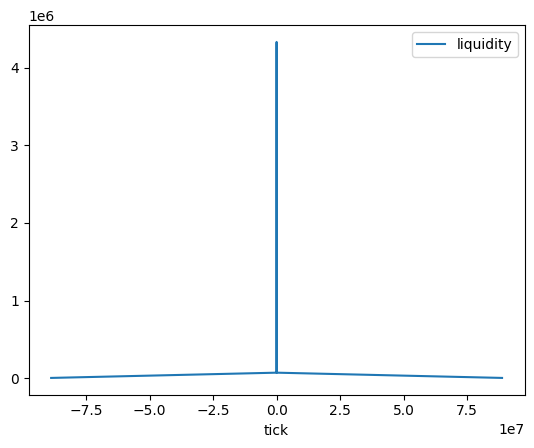

In [256]:
df_total.plot(x='tick', y='liquidity')

<Axes: xlabel='tick'>

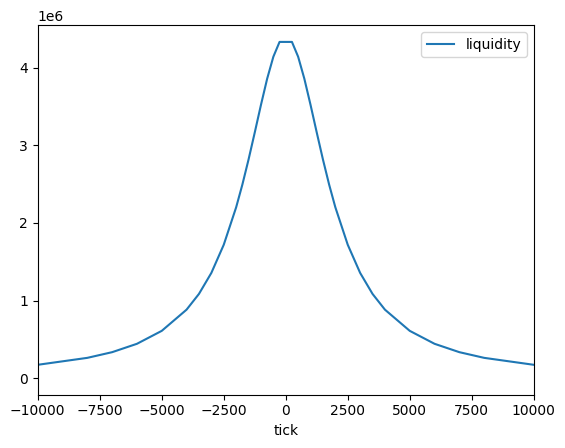

In [257]:
df_total.plot(x='tick', y='liquidity', xlim=(-10000, 10000))

<Axes: xlabel='tick'>

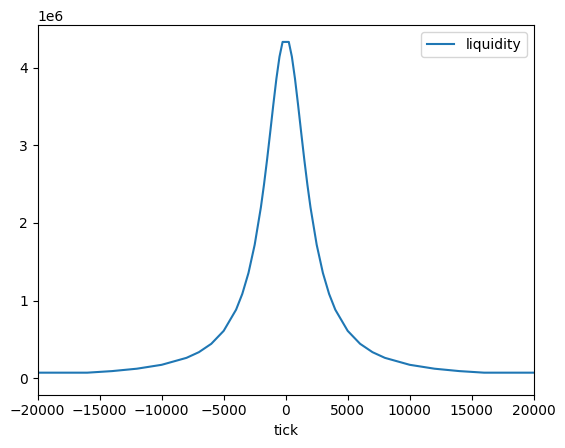

In [258]:
df_total.plot(x='tick', y='liquidity', xlim=(-20000, 20000))

In [259]:
# normalize by pool liquidity factor
(lf, ) = await lp_contract.functions['pool_liquidity_factor'].call(pool_key)
lf

27600000000

In [260]:
GAMMA = 2000
PEG = 64000
mclp = ModifiedCauchyLiquidityProfile(c=lf, gamma=GAMMA, peg=PEG)

In [261]:
df_total['model'] = mclp.at(df_total['tick'])

In [262]:
df_total

,tick,liquidity_delta,liquidity,model
0,-88722883,4285,4285,4.285540e+03
1,-16000,67579,71864,7.186518e+04
2,-14000,20273,92137,9.213907e+04
3,-12000,30868,123005,1.230065e+05
4,-10000,50229,173234,1.732346e+05
5,-8000,89443,262677,2.626783e+05
6,-7000,73130,335807,3.358083e+05
7,-6000,107744,443551,4.435532e+05
8,-5000,166620,610171,6.101719e+05
9,-4000,272649,882820,8.828208e+05


<Axes: xlabel='tick'>

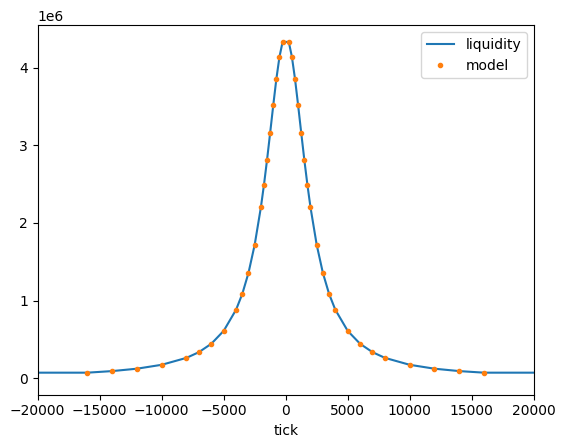

In [263]:
df_total.plot(x='tick', y=['liquidity', 'model'], xlim=(-20000, 20000), style=['-', '.'])